<a href="https://colab.research.google.com/github/ReneeB-prog/DrleeWebSLM/blob/main/Mod2ReneeBernard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
# The available files are: ['restaurant-2-products-price.csv', 'restaurant-1-orders.csv', 'restaurant-2-orders.csv', 'restaurant-1-products-price.csv']
file_path = "restaurant-1-orders.csv"

# Load the latest version
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "henslersoftware/19560-indian-takeaway-orders",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

Using Colab cache for faster access to the '19560-indian-takeaway-orders' dataset.
First 5 records:    Order Number        Order Date            Item Name  Quantity  \
0         16118  03/08/2019 20:25        Plain Papadum         2   
1         16118  03/08/2019 20:25     King Prawn Balti         1   
2         16118  03/08/2019 20:25          Garlic Naan         1   
3         16118  03/08/2019 20:25        Mushroom Rice         1   
4         16118  03/08/2019 20:25  Paneer Tikka Masala         1   

   Product Price  Total products  
0           0.80               6  
1          12.95               6  
2           2.95               6  
3           3.95               6  
4           8.95               6  


In [4]:
import os

dataset_path = '/kaggle/input/19560-indian-takeaway-orders'
print(os.listdir(dataset_path))

['restaurant-2-products-price.csv', '.nfs00000000413e1ee000000165', 'restaurant-1-orders.csv', 'restaurant-2-orders.csv', 'restaurant-1-products-price.csv']


Inspect Data

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
df = pd.read_excel('https://github.com/fenago/datasets/raw/refs/heads/main/Online%20Retail%20(1).xlsx')
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nColumn Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (541909, 8)

First few rows:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non

Clean Data

In [7]:
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
print(f"Clean Dataset: {df.shape[0]} transactions")
print(f"Unique Customers: {df['CustomerID'].nunique()}")
print(f"Date Range: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")

Clean Dataset: 397884 transactions
Unique Customers: 4338
Date Range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00


Calculate Recency, Frequency, Monetary

In [8]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
print(rfm.describe())
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])
rfm['RFM_Segment'] = rfm['R_Score'].astype(int) + rfm['F_Score'].astype(int) + rfm['M_Score'].astype(int)
def segment_customer(row):
    if row['RFM_Segment'] >= 9 and row['R_Score'] >= 4:
        return 'Champions'
    elif row['RFM_Segment'] >= 6 and row['R_Score'] >= 3:
        return 'Loyal Customers'
    elif row['F_Score'] >= 3 and row['R_Score'] >= 3:
        return 'Potential Loyalists'
    elif row['R_Score'] >= 4:
        return 'Recent Customers'
    elif row['RFM_Segment'] >= 6 and row['R_Score'] <= 2:
        return 'At Risk'
    elif row['F_Score'] >= 2 and row['R_Score'] <= 2:
        return 'Cant Lose Them'
    elif row['R_Score'] <= 2:
        return 'Lost'
    else:
        return 'Others'
rfm['Customer_Segment'] = rfm.apply(segment_customer, axis=1)
print("\nCustomer Segments:")
print(rfm['Customer_Segment'].value_counts())

         CustomerID      Recency    Frequency       Monetary
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    92.536422     4.272015    2054.266460
std     1721.808492   100.014169     7.697998    8989.230441
min    12346.000000     1.000000     1.000000       3.750000
25%    13813.250000    18.000000     1.000000     307.415000
50%    15299.500000    51.000000     2.000000     674.485000
75%    16778.750000   142.000000     5.000000    1661.740000
max    18287.000000   374.000000   209.000000  280206.020000

Customer Segments:
Customer_Segment
Champions          1520
Loyal Customers    1043
At Risk             892
Lost                485
Cant Lose Them      331
Others               67
Name: count, dtype: int64


Visualize RFM Distributions

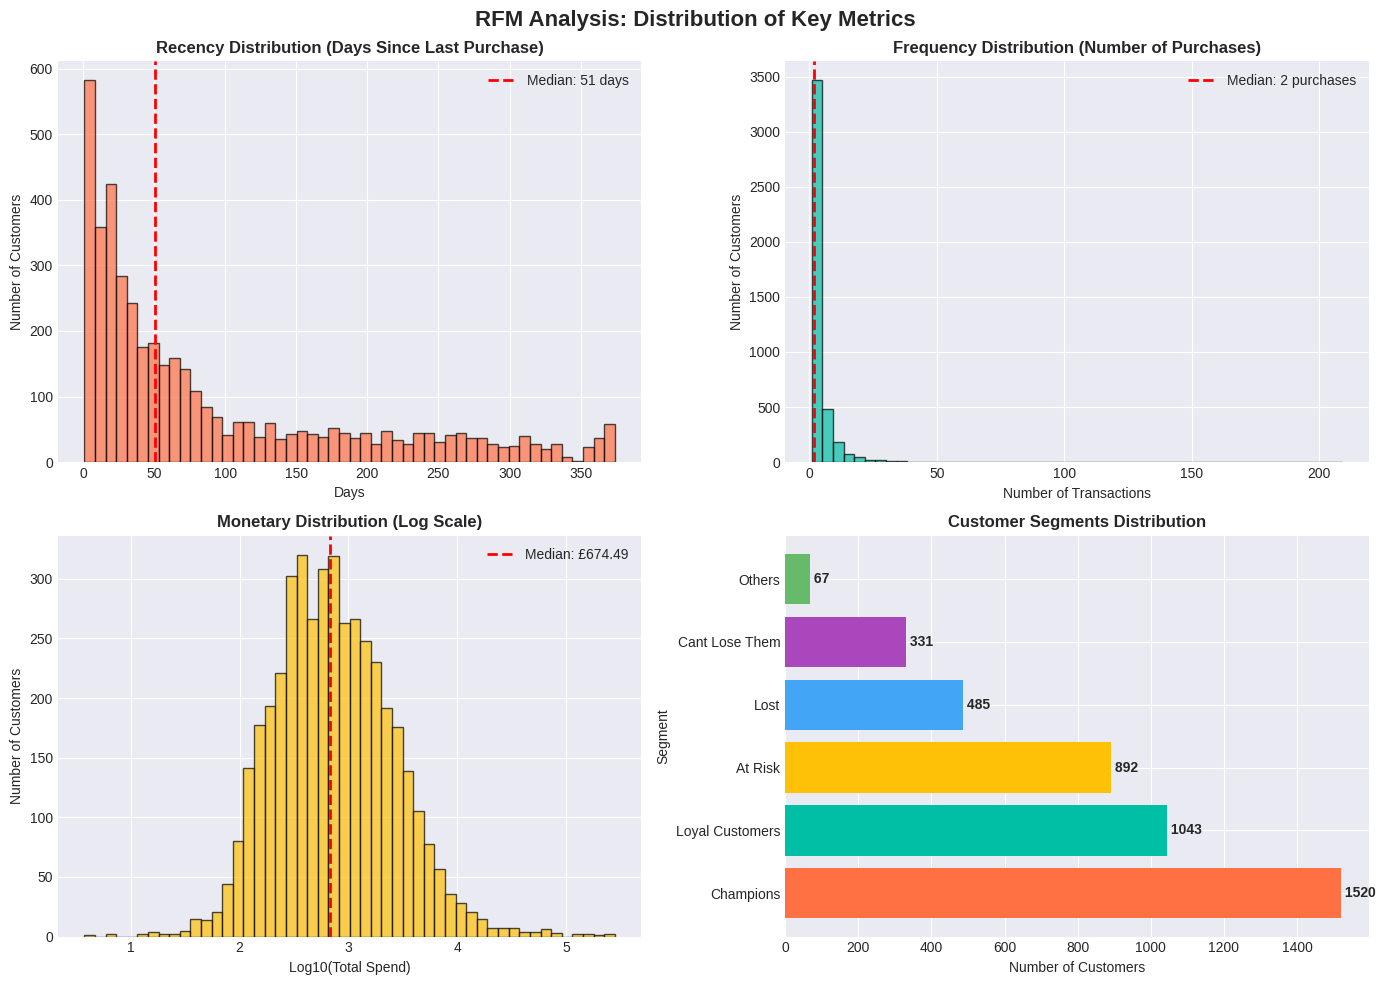

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('RFM Analysis: Distribution of Key Metrics', fontsize=16, fontweight='bold')
axes[0, 0].hist(rfm['Recency'], bins=50, color='#FF7043', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Recency Distribution (Days Since Last Purchase)', fontweight='bold')
axes[0, 0].set_xlabel('Days')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].axvline(rfm['Recency'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {rfm["Recency"].median():.0f} days')
axes[0, 0].legend()
axes[0, 1].hist(rfm['Frequency'], bins=50, color='#00BFA5', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Frequency Distribution (Number of Purchases)', fontweight='bold')
axes[0, 1].set_xlabel('Number of Transactions')
axes[0, 1].set_ylabel('Number of Customers')
axes[0, 1].axvline(rfm['Frequency'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {rfm["Frequency"].median():.0f} purchases')
axes[0, 1].legend()
axes[1, 0].hist(np.log10(rfm['Monetary']), bins=50, color='#FFC107', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Monetary Distribution (Log Scale)', fontweight='bold')
axes[1, 0].set_xlabel('Log10(Total Spend)')
axes[1, 0].set_ylabel('Number of Customers')
axes[1, 0].axvline(np.log10(rfm['Monetary'].median()), color='red', linestyle='--', linewidth=2, label=f'Median: £{rfm["Monetary"].median():.2f}')
axes[1, 0].legend()
segment_counts = rfm['Customer_Segment'].value_counts()
colors_palette = ['#FF7043', '#00BFA5', '#FFC107', '#42A5F5', '#AB47BC', '#66BB6A']
axes[1, 1].barh(segment_counts.index, segment_counts.values, color=colors_palette[:len(segment_counts)])
axes[1, 1].set_title('Customer Segments Distribution', fontweight='bold')
axes[1, 1].set_xlabel('Number of Customers')
axes[1, 1].set_ylabel('Segment')
for i, v in enumerate(segment_counts.values):
    axes[1, 1].text(v, i, f' {v}', va='center', fontweight='bold')
plt.tight_layout()
plt.show()

Calculate Customer Lifetime Value

In [10]:
cltv_data = df.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum',
    'InvoiceDate': lambda x: (x.max() - x.min()).days
}).reset_index()
cltv_data.columns = ['CustomerID', 'NumPurchases', 'TotalRevenue', 'CustomerLifespan']
cltv_data['AvgOrderValue'] = cltv_data['TotalRevenue'] / cltv_data['NumPurchases']
cltv_data['PurchaseFrequency'] = cltv_data['NumPurchases'] / (cltv_data['CustomerLifespan'] + 1) * 365
cltv_data['CustomerLifespanYears'] = (cltv_data['CustomerLifespan'] + 1) / 365
cltv_data['CLTV'] = cltv_data['AvgOrderValue'] * cltv_data['PurchaseFrequency'] * cltv_data['CustomerLifespanYears']
print("CLTV Summary:")
print(cltv_data['CLTV'].describe())
print(f"\nTotal CLTV: £{cltv_data['CLTV'].sum():,.2f}")
print(f"Average CLTV: £{cltv_data['CLTV'].mean():,.2f}")
print(f"Median CLTV: £{cltv_data['CLTV'].median():,.2f}")

CLTV Summary:
count      4338.000000
mean       2054.266460
std        8989.230441
min           3.750000
25%         307.415000
50%         674.485000
75%        1661.740000
max      280206.020000
Name: CLTV, dtype: float64

Total CLTV: £8,911,407.90
Average CLTV: £2,054.27
Median CLTV: £674.49


Visualize CLTV Insights

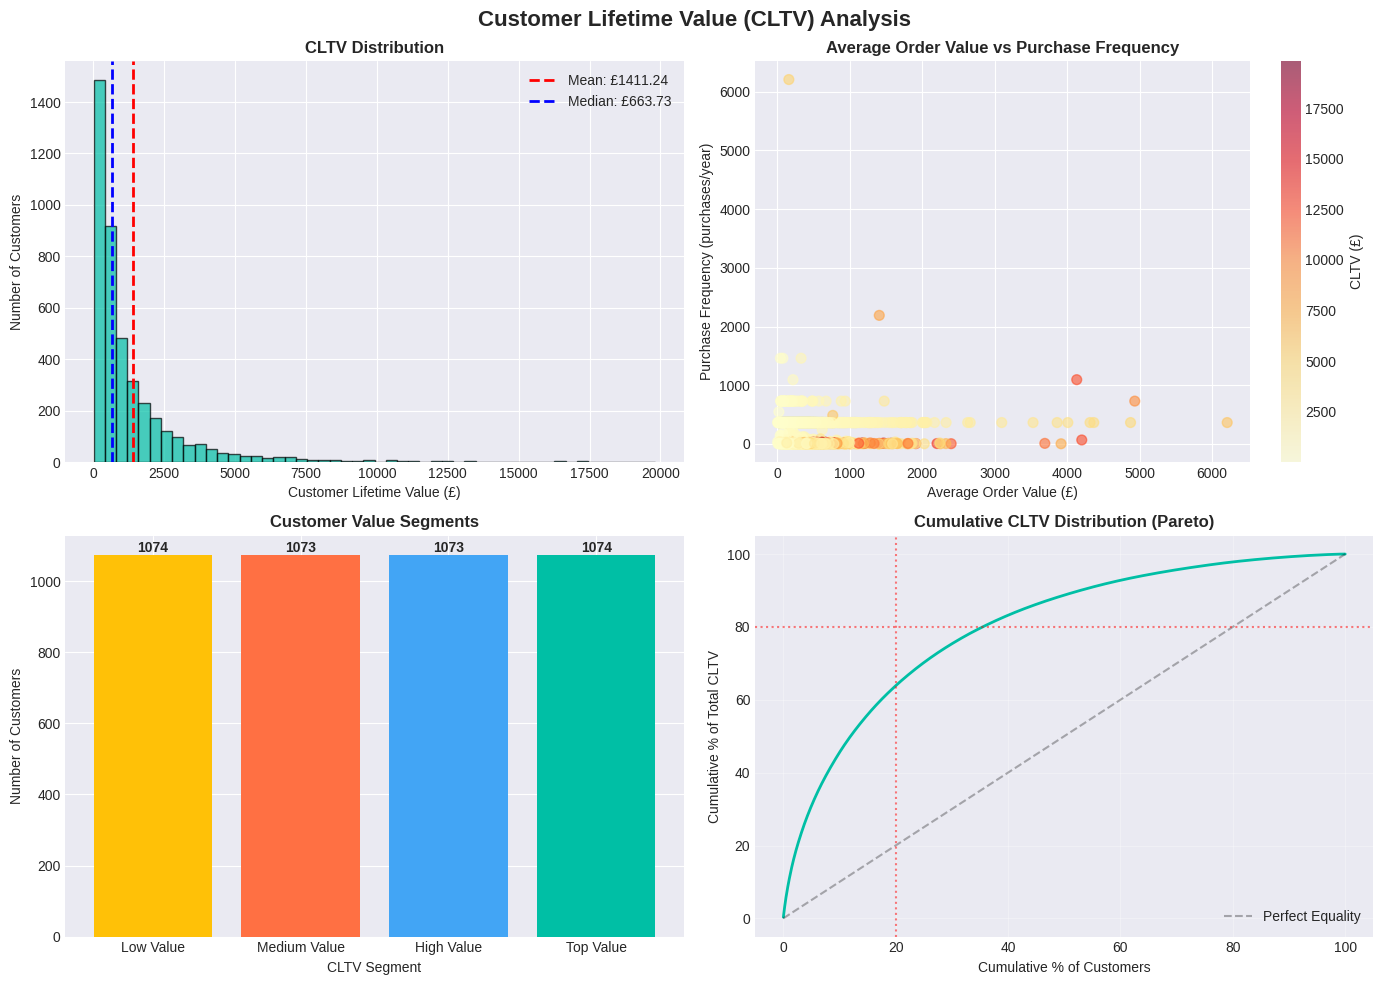

In [11]:
cltv_data_clean = cltv_data[cltv_data['CLTV'] <= cltv_data['CLTV'].quantile(0.99)]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Customer Lifetime Value (CLTV) Analysis', fontsize=16, fontweight='bold')
axes[0, 0].hist(cltv_data_clean['CLTV'], bins=50, color='#00BFA5', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('CLTV Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Customer Lifetime Value (£)')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].axvline(cltv_data_clean['CLTV'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: £{cltv_data_clean["CLTV"].mean():.2f}')
axes[0, 0].axvline(cltv_data_clean['CLTV'].median(), color='blue', linestyle='--', linewidth=2, label=f'Median: £{cltv_data_clean["CLTV"].median():.2f}')
axes[0, 0].legend()
scatter = axes[0, 1].scatter(cltv_data_clean['AvgOrderValue'], cltv_data_clean['PurchaseFrequency'], c=cltv_data_clean['CLTV'], cmap='YlOrRd', alpha=0.6, s=50)
axes[0, 1].set_title('Average Order Value vs Purchase Frequency', fontweight='bold')
axes[0, 1].set_xlabel('Average Order Value (£)')
axes[0, 1].set_ylabel('Purchase Frequency (purchases/year)')
plt.colorbar(scatter, ax=axes[0, 1], label='CLTV (£)')
cltv_quartiles = pd.qcut(cltv_data_clean['CLTV'], q=4, labels=['Low Value', 'Medium Value', 'High Value', 'Top Value'])
segment_counts = cltv_quartiles.value_counts().sort_index()
colors = ['#FFC107', '#FF7043', '#42A5F5', '#00BFA5']
axes[1, 0].bar(segment_counts.index, segment_counts.values, color=colors)
axes[1, 0].set_title('Customer Value Segments', fontweight='bold')
axes[1, 0].set_xlabel('CLTV Segment')
axes[1, 0].set_ylabel('Number of Customers')
for i, v in enumerate(segment_counts.values):
    axes[1, 0].text(i, v, f'{v}', ha='center', va='bottom', fontweight='bold')
sorted_cltv = cltv_data_clean.sort_values('CLTV', ascending=False)
sorted_cltv['CumulativePercent'] = (sorted_cltv['CLTV'].cumsum() / sorted_cltv['CLTV'].sum()) * 100
sorted_cltv['CustomerPercent'] = (np.arange(1, len(sorted_cltv) + 1) / len(sorted_cltv)) * 100
axes[1, 1].plot(sorted_cltv['CustomerPercent'], sorted_cltv['CumulativePercent'], color='#00BFA5', linewidth=2)
axes[1, 1].plot([0, 100], [0, 100], 'k--', alpha=0.3, label='Perfect Equality')
axes[1, 1].set_title('Cumulative CLTV Distribution (Pareto)', fontweight='bold')
axes[1, 1].set_xlabel('Cumulative % of Customers')
axes[1, 1].set_ylabel('Cumulative % of Total CLTV')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axvline(20, color='red', linestyle=':', alpha=0.5)
axes[1, 1].axhline(80, color='red', linestyle=':', alpha=0.5)
axes[1, 1].legend()
plt.tight_layout()
plt.show()

Apply KMeans and Interpret Clusters

In [13]:
# Select features for clustering
X = rfm[['Recency', 'Frequency', 'Monetary']]
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Apply KMeans clustering
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)
# Analyze cluster characteristics
cluster_summary = rfm.groupby('KMeans_Cluster').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median'],
    'CustomerID': 'count'
}).round(2)
print("Cluster Analysis:")
print(cluster_summary)

Cluster Analysis:
               Recency        Frequency          Monetary             \
                  mean median      mean median       mean     median   
KMeans_Cluster                                                         
0                43.70   32.0      3.68    3.0    1359.05     829.30   
1               248.08  243.0      1.55    1.0     480.62     310.47   
2                 7.38    2.0     82.54   63.0  127338.31  117379.63   
3                15.50    5.0     22.33   19.0   12709.09    8037.73   

               CustomerID  
                    count  
KMeans_Cluster             
0                    3054  
1                    1067  
2                      13  
3                     204  


Visualize KMeans Clusters

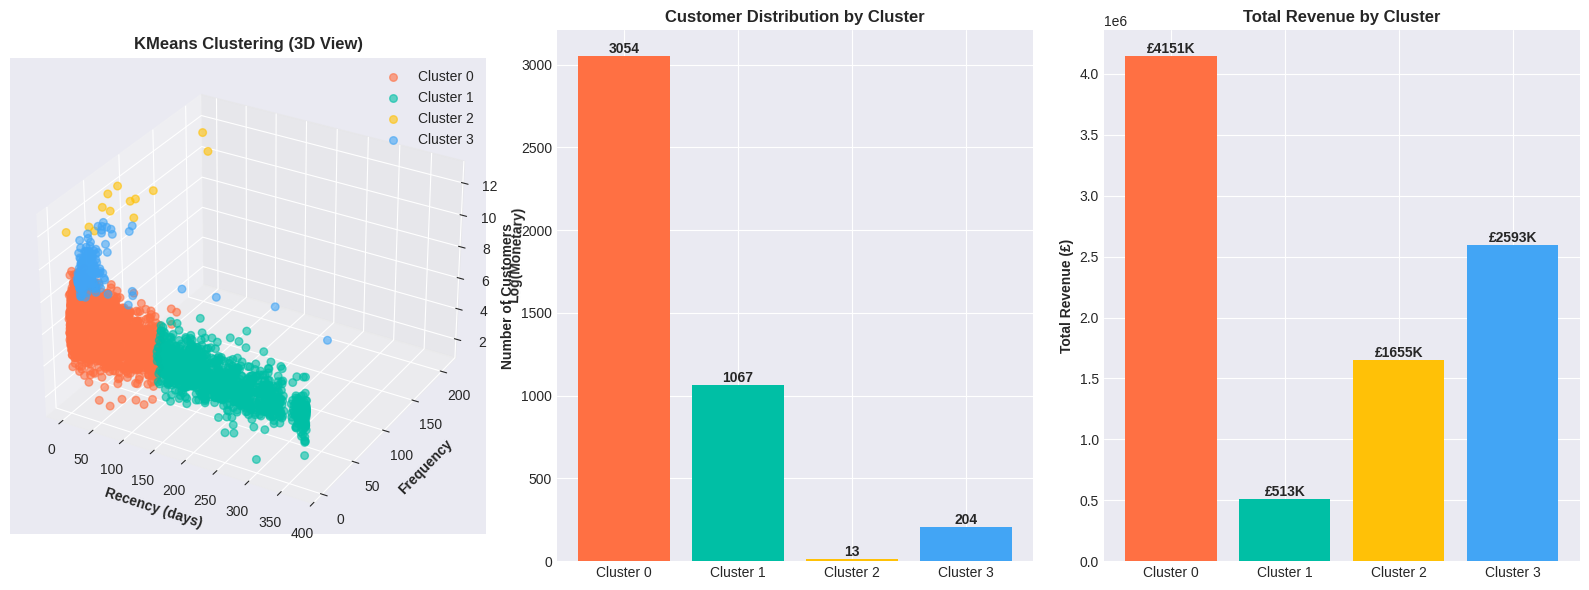

In [14]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(131, projection='3d')
colors = ['#FF7043', '#00BFA5', '#FFC107', '#42A5F5']
for i in range(optimal_k):
    cluster_data = rfm[rfm['KMeans_Cluster'] == i]
    ax1.scatter(cluster_data['Recency'], cluster_data['Frequency'], np.log1p(cluster_data['Monetary']), c=colors[i], label=f'Cluster {i}', alpha=0.6, s=30)
ax1.set_xlabel('Recency (days)', fontweight='bold')
ax1.set_ylabel('Frequency', fontweight='bold')
ax1.set_zlabel('Log(Monetary)', fontweight='bold')
ax1.set_title('KMeans Clustering (3D View)', fontweight='bold', fontsize=12)
ax1.legend()
ax2 = fig.add_subplot(132)
cluster_counts = rfm['KMeans_Cluster'].value_counts().sort_index()
ax2.bar(range(len(cluster_counts)), cluster_counts.values, color=colors)
ax2.set_xticks(range(len(cluster_counts)))
ax2.set_xticklabels([f'Cluster {i}' for i in range(optimal_k)])
ax2.set_title('Customer Distribution by Cluster', fontweight='bold', fontsize=12)
ax2.set_ylabel('Number of Customers', fontweight='bold')
for i, v in enumerate(cluster_counts.values):
    ax2.text(i, v, f'{v}', ha='center', va='bottom', fontweight='bold')
ax3 = fig.add_subplot(133)
cluster_revenue = rfm.groupby('KMeans_Cluster')['Monetary'].sum().sort_index()
ax3.bar(range(len(cluster_revenue)), cluster_revenue.values, color=colors)
ax3.set_xticks(range(len(cluster_revenue)))
ax3.set_xticklabels([f'Cluster {i}' for i in range(optimal_k)])
ax3.set_title('Total Revenue by Cluster', fontweight='bold', fontsize=12)
ax3.set_ylabel('Total Revenue (£)', fontweight='bold')
for i, v in enumerate(cluster_revenue.values):
    ax3.text(i, v, f'£{v/1000:.0f}K', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()